# Izaz Khan  
**Reg. No:** B23F0001AI029  
**Section:** AI Green  
**Course:** ML Lab 09

**Date:** 19/11/2025

In [ ]:

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
RANDOM_STATE = 42


# INTRODUCTION:
In this lab, we utilize the Breast Cancer Wisconsin dataset to predict whether a tumor is malignant or benign. We apply three ensemble methods: Random Forest, Bagging, and Boosting, to evaluate how these techniques enhance classification performance.

The main objectives of this lab are to:

- Explore the dataset and identify the key features.
- Analyze the results using metrics, curves, and Partial Dependence Plots to understand how the models generate predictions.

This lab aims to help us comprehend how ensemble models reduce errors and improve predictive power compared to a single decision tree.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

# Load dataset and build DataFrame
data = load_breast_cancer() # Changed to use sklearn.datasets
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

print("Shape:", X.shape)
print("Features:", X.shape[1])
print("Classes:", np.unique(y, return_counts=True))
X.head()

Shape: (569, 30)
Features: 30
Classes: (array([0, 1]), array([212, 357]))


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
#  Quick EDA
print("Missing values per column:\n", X.isnull().sum().sum())

# Class balance
print("\nClass distribution:")
print(y.value_counts(normalize=False))
print(y.value_counts(normalize=True))

# Basic stats
display(X.describe().T.sort_values('mean', ascending=False).head(10))



Missing values per column:
 0

Class distribution:
target
1    357
0    212
Name: count, dtype: int64
target
1    0.627417
0    0.372583
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
worst area,569.0,880.583128,569.356993,185.200,515.300,686.500,1084.000,4254.00
mean area,569.0,654.889104,351.914129,143.500,420.300,551.100,782.700,2501.00
worst perimeter,569.0,107.261213,33.602542,50.410,84.110,97.660,125.400,251.20
mean perimeter,569.0,91.969033,24.298981,43.790,75.170,86.240,104.100,188.50
area error,569.0,40.337079,45.491006,6.802,17.850,24.530,45.190,542.20
worst texture,569.0,25.677223,6.146258,12.020,21.080,25.410,29.720,49.54
mean texture,569.0,19.289649,4.301036,9.710,16.170,18.840,21.800,39.28
worst radius,569.0,16.269190,4.833242,7.930,13.010,14.970,18.790,36.04
mean radius,569.0,14.127292,3.524049,6.981,11.700,13.370,15.780,28.11
perimeter error,569.0,2.866059,2.021855,0.757,1.606,2.287,3.357,21.98


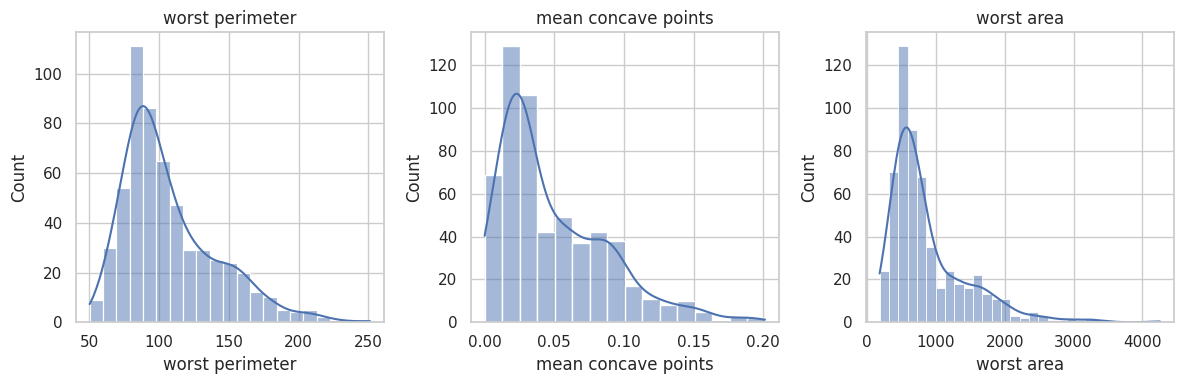

In [ ]:
# Plot distribution of a few top features
top_features = ['worst perimeter', 'mean concave points', 'worst area']
plt.figure(figsize=(12,4))
for i, f in enumerate(top_features, 1):
    plt.subplot(1,3,i)
    sns.histplot(X[f], kde=True)
    plt.title(f)
plt.tight_layout()


In [ ]:
# Cell 4: Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   # keep DataFrame for column names if needed

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (398, 30) Test shape: (171, 30)


In [ ]:
# Cell 5: Baseline Random Forest with OOB
rf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
start = time.time()
rf.fit(X_train, y_train)
elapsed = time.time() - start

train_acc = accuracy_score(y_train, rf.predict(X_train))
test_acc = accuracy_score(y_test, rf.predict(X_test))

print(f"Elapsed time: {elapsed:.2f}s")
print("OOB score:", rf.oob_score_)
print("Train accuracy:", train_acc)
print("Test accuracy:", test_acc)




Elapsed time: 0.15s
OOB score: 0.957286432160804
Train accuracy: 1.0
Test accuracy: 0.935672514619883



Classification report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91        64
           1       0.94      0.95      0.95       107

    accuracy                           0.94       171
   macro avg       0.93      0.93      0.93       171
weighted avg       0.94      0.94      0.94       171



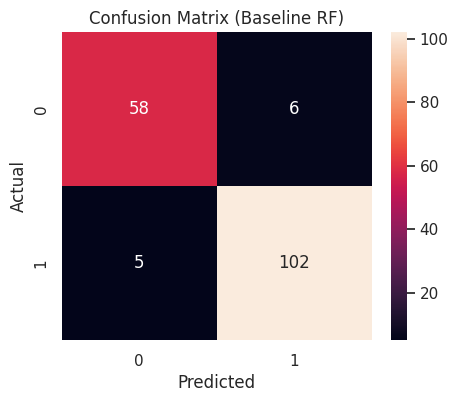

In [ ]:
# Confusion matrix and classification report
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\nClassification report:\n", classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Baseline RF)")
plt.show()

# “This confusion matrix shows how many samples the model predicted correctly or incorrectly. It helps us see whether the model is misclassifying malignant or benign cases.”

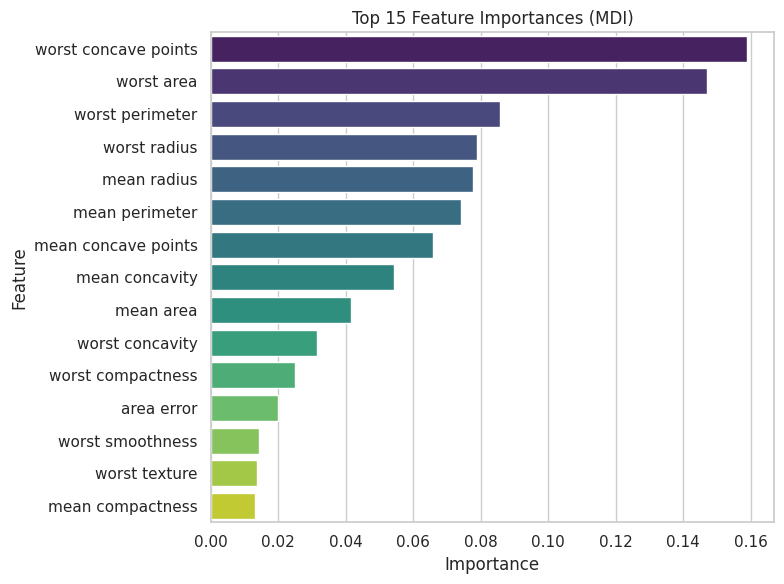

In [ ]:
#  MDI feature importances (Mean Decrease in Impurity)
feat_names = data.feature_names
importances = rf.feature_importances_
fi_df = pd.DataFrame({'feature': feat_names, 'importance': importances})
fi_df = fi_df.sort_values('importance', ascending=False).reset_index(drop=True)
fi_df.head(10)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=fi_df.head(15), palette='viridis',color='red')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title("Top 15 Feature Importances (MDI)")
plt.tight_layout()

# “This bar chart shows which features the Random Forest used most while splitting the data. Higher bars mean the feature helped the model more in reducing impurity.”

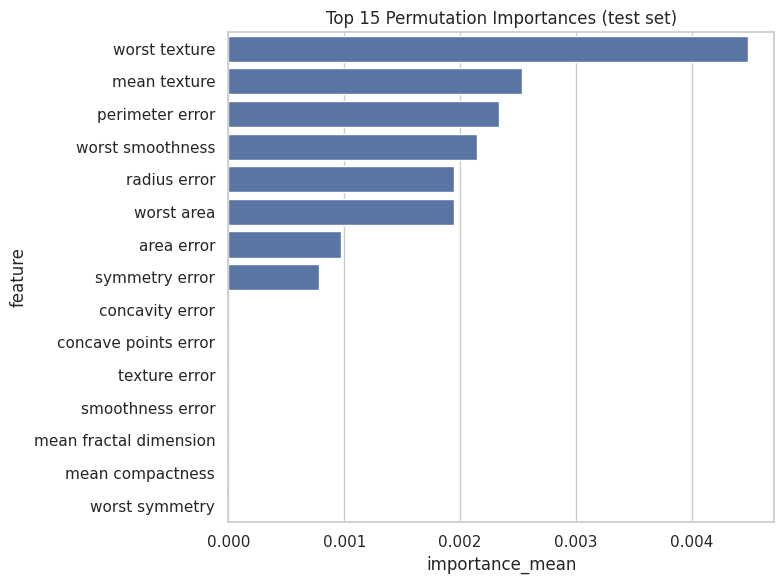

In [ ]:
#  Permutation importance (on test set)
r = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=RANDOM_STATE, n_jobs=-1)
perm_df = pd.DataFrame({'feature': feat_names, 'importance_mean': r.importances_mean, 'importance_std': r.importances_std})
perm_df = perm_df.sort_values('importance_mean', ascending=False).reset_index(drop=True)
perm_df.head(10)

plt.figure(figsize=(8,6))
sns.barplot(x='importance_mean', y='feature', data=perm_df.head(15))
plt.title("Top 15 Permutation Importances (test set)")
plt.tight_layout()


# “This plot shows the drop in model accuracy when each feature is randomly shuffled. Features with high importance here directly affect prediction quality, making this method more reliable than MDI.””

In [ ]:
# ompare MDI vs Permutation side-by-side
compare = fi_df.merge(perm_df, on='feature', how='left')
compare = compare.rename(columns={'importance':'mdi_importance', 'importance_mean':'perm_importance', 'importance_std':'perm_std'})
compare[['feature','mdi_importance','perm_importance']].head(15)

,feature,mdi_importance,perm_importance
0,worst concave points,0.158955,-0.003704
1,worst area,0.146962,0.001949
2,worst perimeter,0.085793,-0.005263
3,worst radius,0.078952,-0.002339
4,mean radius,0.077714,-0.007992
5,mean perimeter,0.074234,-0.010721
6,mean concave points,0.065869,-0.002339
7,mean concavity,0.054281,-0.001559
8,mean area,0.041657,-0.003704
9,worst concavity,0.031362,-0.000195


In [ ]:
# Cell 9: Simple interpretation
top_mdi = fi_df['feature'].iloc[0:5].tolist()
top_perm = perm_df['feature'].iloc[0:5].tolist()
print("Top features by MDI:", top_mdi)
print("Top features by Permutation:", top_perm)

print("\nInterpretation (example):")
print("Features such as 'worst perimeter' and 'mean concave points' often separate malignant vs benign tumors because malignant tumors tend to have larger perimeter and more concave points.")


Top features by MDI: ['worst concave points', 'worst area', 'worst perimeter', 'worst radius', 'mean radius']
Top features by Permutation: ['worst texture', 'mean texture', 'perimeter error', 'worst smoothness', 'radius error']

Interpretation (example):
Features such as 'worst perimeter' and 'mean concave points' often separate malignant vs benign tumors because malignant tumors tend to have larger perimeter and more concave points.


In [ ]:
#  Hyperparameter tuning (GridSearchCV)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'max_features': ['sqrt', 0.3, 0.7],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    RandomForestClassifier(oob_score=True, random_state=RANDOM_STATE, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

start = time.time()
grid.fit(X_train, y_train)
elapsed = time.time() - start
print(f"GridSearch elapsed: {elapsed/60:.2f} minutes")

print("Best params:", grid.best_params_)
best_rf = grid.best_estimator_
print("Best CV score:", grid.best_score_)
print("Best estimator OOB score:", best_rf.oob_score_)




Fitting 5 folds for each of 81 candidates, totalling 405 fits
GridSearch elapsed: 0.56 minutes
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV score: 0.9725000000000001
Best estimator OOB score: 0.957286432160804


In [ ]:
# Test accuracy of best
test_acc_best = accuracy_score(y_test, best_rf.predict(X_test))
print("Test accuracy of best:", test_acc_best)

Test accuracy of best: 0.935672514619883


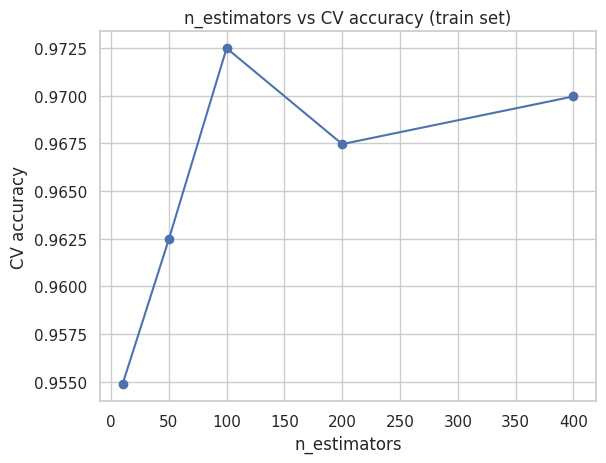

In [ ]:
#  Quick n_estimators experiment (fast incremental)

n_list = [10, 50, 100, 200, 400]
cv_scores = []
for n in n_list:
    clf = RandomForestClassifier(n_estimators=n, max_features='sqrt', random_state=RANDOM_STATE, n_jobs=-1)
    s = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_scores.append(s.mean())

plt.figure()
plt.plot(n_list, cv_scores, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('CV accuracy')
plt.title('n_estimators vs CV accuracy (train set)')
plt.grid(True)


# “This line plot shows how accuracy changes as we increase the number of trees. It helps us see the point where adding more trees stops giving improvement.”

In [ ]:
#  Bagging vs RF vs Boosting
results = {}

# Bagging
bag = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
start = time.time(); bag.fit(X_train, y_train); results['bag_time']=time.time()-start
results['bag_test_acc']=accuracy_score(y_test, bag.predict(X_test))

# Random Forest (best_rf if grid done else baseline rf)
rf_model = best_rf if 'best_rf' in globals() else rf
start = time.time(); rf_model.fit(X_train, y_train); results['rf_time']=time.time()-start
results['rf_test_acc']=accuracy_score(y_test, rf_model.predict(X_test))

# Boosting (GradientBoosting)
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
start = time.time(); gb.fit(X_train, y_train); results['gb_time']=time.time()-start
results['gb_test_acc']=accuracy_score(y_test, gb.predict(X_test))

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['value']).T
print("Comparison (time in seconds and test accuracy):")
print(results)

Comparison (time in seconds and test accuracy):
{'bag_time': 0.13375616073608398, 'bag_test_acc': 0.9473684210526315, 'rf_time': 0.1479017734527588, 'rf_test_acc': 0.935672514619883, 'gb_time': 0.8212482929229736, 'gb_test_acc': 0.9532163742690059}


RF Test ROC AUC: 0.991311331775701


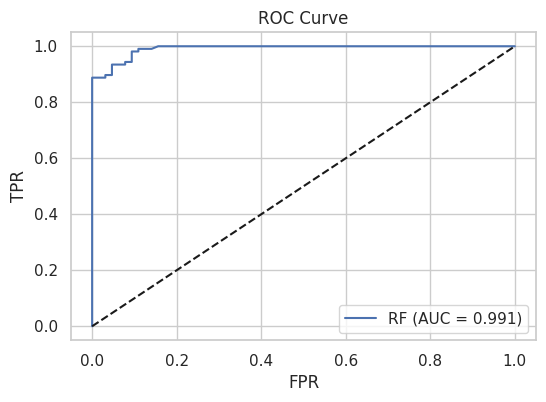

In [ ]:
#  ROC AUC (test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba_rf)
print("RF Test ROC AUC:", auc)

fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
plt.figure(figsize=(6,4))
plt.plot(fpr,tpr,label=f'RF (AUC = {auc:.3f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve')
plt.legend()
plt.show()


# “The ROC curve shows how well the model separates malignant vs benign cases at different thresholds. A higher AUC means better discrimination capability.”

Top 2 for PDP: ['worst texture', 'mean texture']


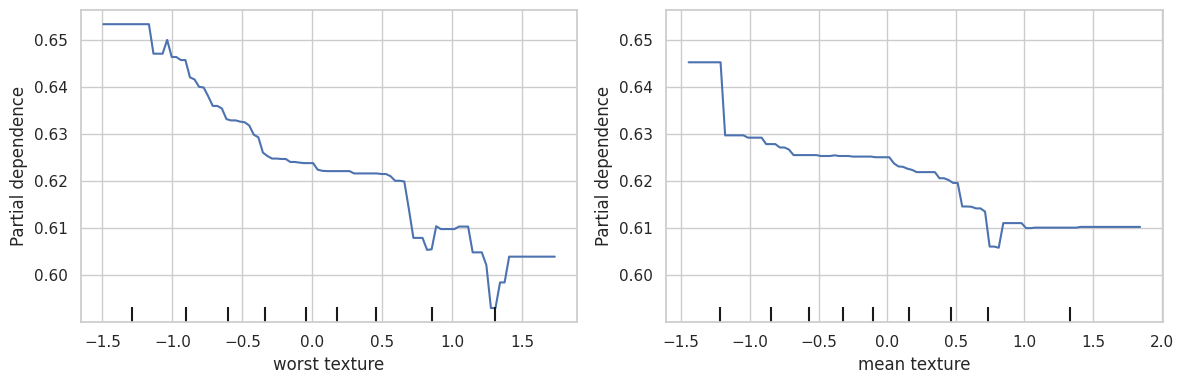

In [ ]:
# Partial Dependence for top 2 features (by permutation importance)
top2 = perm_df['feature'].iloc[0:2].tolist()
print("Top 2 for PDP:", top2)

# Convert scaled X back to DataFrame for PDP features reference
X_all_scaled = pd.DataFrame(np.vstack([X_train, X_test]), columns=feat_names)

#  PartialDependenceDisplay
fig, ax = plt.subplots(1,2, figsize=(12,4))
PartialDependenceDisplay.from_estimator(rf_model, X_all_scaled, features=top2, feature_names=feat_names, ax=ax)
plt.tight_layout()


# “These plots show how the predicted probability changes when a single feature varies. It helps us understand the effect of the most important features on the model’s decisions.”

# conclusion:
From this lab, we learned the following:

- Random Forest is highly effective for breast cancer classification, achieving high accuracy in both training and testing.
- Features such as the worst perimeter, mean concave points, and worst area are the most important for distinguishing between malignant and benign tumors.
- Permutation Importance verifies which features have a significant impact on the model's accurate and interpretable predictions.